In [1]:
import numpy as np
from numba import cuda
import numba as numba
import math
import matplotlib.pyplot as plt

def gpu_total_memory():
    return cuda.current_context().get_memory_info()[1]

def gpu_compute_capability():
    return cuda.get_current_device().compute_capability

def gpu_name():
    return cuda.get_current_device().name

def max_float64s():
    return gpu_total_memory()/8

def map_64():
    from map_parallel import sArray
    M = max_float64s()
    N = int(M/2)
    x = np.linspace(0,1,N,dtype = np.float64)
    y = sArray(x)
    plt.plot(x,y)

GPU memory in GB:  2.0
Compute capability (Major, Minor):  (6, 1)
GPU Model Name:  b'GeForce MX150'
Max float64 count:  268435456.0


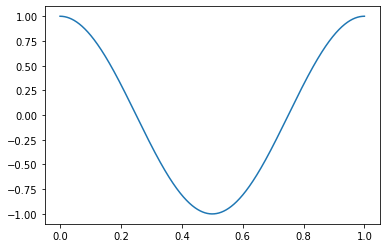

In [2]:
print("GPU memory in GB: ", gpu_total_memory()/1024**3)
print("Compute capability (Major, Minor): ", gpu_compute_capability())
print("GPU Model Name: ", gpu_name())
print("Max float64 count: ", max_float64s())
map_64()

In [3]:
#Problem 3
#parallel
@cuda.jit(device = True)
def f(x, r):
    '''
    Execute 1 iteration of the logistic map
    '''
    return r*x*(1 - x)

In [4]:
@cuda.jit
def logistic_map_kernel(ss, r, x, transient, steady):
    '''
    Kernel for parallel iteration of logistic map

    Arguments:
        ss: 2D numpy device array to store steady state iterates for each value of r
        r: 1D  numpy device array of parameter values
        x: float initial value
        transient: int number of iterations before storing results
        steady: int number of iterations to store
    '''
    n = len(r)
    i = cuda.grid(1)
    ss[0,i] = f(x,r[i])
    if i < n:
        for k in range(transient):
            ss[0,i] = f(ss[0,i],r[i])
        for k in range(steady):
            ss[k+1,i] = f(ss[k,i],r[i])

In [5]:
def parallel_logistic_map(r, x, transient, steady):
    '''
    Parallel iteration of the logistic map

    Arguments:
        r: 1D numpy array of float64 parameter values
        x: float initial value
        transient: int number of iterations before storing results
        steady: int number of iterations to store
    Return:
        2D numpy array of steady iterates for each entry in r
    '''
    TPB = 32
    n = len(r)
    d_r = cuda.to_device(r)
    ss = cuda.device_array((steady,n), dtype = np.float64)
    blockDims = TPB
    gridDims = (n+TPB-1)//TPB
    logistic_map_kernel[gridDims, blockDims](ss, d_r, x, transient, steady)
    return ss.copy_to_host()

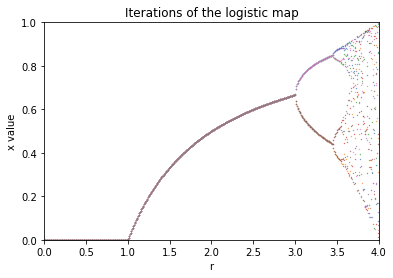

The time of parallel map is 0.002993345260620117 seconds


In [16]:
import time
transient = 1000
steady = 8
x = 0.5
r = np.linspace(0,4,500)
start = time.time()
ss = parallel_logistic_map(r , x , transient , steady)
end = time.time()
p_time = end - start
for i in range(steady):
    plt.scatter(r,ss[i,:],s = 0.1)
plt.axis([0,4, 0, 1])
plt.xlabel('r')
plt.ylabel('x value')
plt.title('Iterations of the logistic map')
plt.show()
print('The time of parallel map is '+str(p_time)+' seconds')

In [7]:
#serial
def s_f(x,r):
    return r*x*(1 - x)

In [8]:
def serial_logistic_map(r,x,transient,steady):
    n = len(r)
    s = np.zeros((steady,n))
    tmp = np.zeros(n)
    for k in range(n):
        tmp[k] = s_f(x,r[k])
    for i in range(n):
        for j in range(transient):
            tmp[i] = s_f(tmp[i],r[i])
        for j in range(steady):
            tmp[i] = s_f(tmp[i],r[i])
            s[j,i] = tmp[i]
    return s

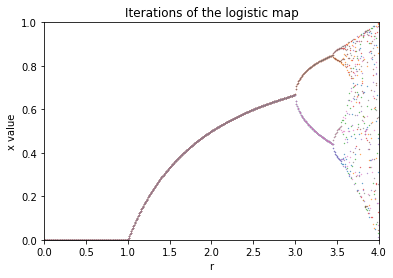

The time of serial map is 0.47606587409973145 seconds


In [9]:
start = time.time()
s = serial_logistic_map(r,x,transient,steady)
end = time.time()
s_time = end - start
for i in range(steady):
    plt.scatter(r,s[i,:],s = 0.1)
plt.axis([0,4, 0, 1])
plt.xlabel('r')
plt.ylabel('x value')
plt.title('Iterations of the logistic map')
plt.show()
print('The time of serial map is '+str(s_time)+' seconds')

In [17]:
print('The acceleration factor is '+ str(s_time/p_time))

The acceleration factor is 159.04141776184787


In [11]:
#Problem 4
#parallel
@cuda.jit(device = True)
def iteration_count(cx, cy, dist, itrs):
    '''
    Computed number of Mandelbrot iterations

    Arguments:
        cx, cy: float64 parameter values
        dist: float64 escape threshold
        itrs: int iteration count limit
    '''
    z = complex(0,0)
    for k in range(itrs):
        z = z*z + complex(cx,cy)
        if abs(z) > dist:
            break
    if k < 255:
        return 1
    else:
        return 0


In [12]:
@cuda.jit
def mandelbrot_kernel(out, cx, cy, dist, itrs):
    '''
    Kernel for parallel computation of Mandelbrot iteration counts

    Arguments:
        out: 2D numpy device array for storing computed iteration counts
        cx, cy: 1D numpy device arrays of parameter values
        dist: float64 escape threshold
        itrs: int iteration count limit
    '''
    i,j = cuda.grid(2)
    nx,ny = out.shape
    if i < nx and j < ny:
        out[i,j] = iteration_count(cx[j],cy[i],dist,itrs)

In [13]:
def parallel_mandelbrot(cx, cy, dist, itrs):
    '''
    Parallel computation of Mandelbrot iteration counts

    Arguments:
        cx, cy: 1D numpy arrays of parameter values
        dist: float64 escape threshold
        itrs: int iteration count limit
    Return:
        2D numpy array of iteration counts
    '''
    TPBx = 32
    TPBy = 32
    lex = len(cx)
    ley = len(cy)
    d_cx = cuda.to_device(cx)
    d_cy = cuda.to_device(cy)
    blockDims = (TPBx,TPBy)
    gridDims = ((lex+TPBx-1)//TPBx , (ley+TPBy-1)//TPBy)
    out = cuda.device_array((lex,ley), dtype = np.float64)
    mandelbrot_kernel[gridDims, blockDims](out, d_cx, d_cy, dist, itrs)
    return out.copy_to_host()

The parallel_mandelbrot took 0.6091592311859131 seconds


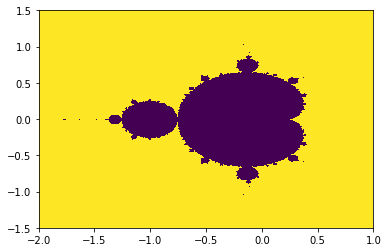

In [14]:
gg = 2048
cx = np.linspace(-2,1,gg)
cy = np.linspace(-1.5,1.5,gg)
start = time.time()
arr = parallel_mandelbrot(cx,cy,2.5,256)
end = time.time()
plt.pcolormesh(cx,cy,arr)
print('The parallel_mandelbrot took '+str(end-start)+' seconds')